In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime
import warnings
import math
warnings.filterwarnings(action='ignore', category=FutureWarning)

import custom_dataset as ds

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
class model_wrapper:
    def __init__(self, model):
        self.model = model
    
    def train_model(self, dataset, epoch, batch_size=16, lr=0.001, decay=0.99):
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.model.train()
        for epoch in range(epoch):        
            epoch_loss = 0
            for X, X_t, y, y_t in tqdm(dataloader):
                optimizer.zero_grad()
                X = X.to(self.model.device)
                X_t = X_t.to(self.model.device)

                y_pred = self.model((X, X_t))
                loss = criterion(y_pred.cpu().squeeze(), y.squeeze())
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()      

            scheduler.step()
            print(f'Epoch {epoch+1}, MSE Loss: {epoch_loss/len(dataloader)}')
            
    def inference_model(self, dataset, batch_size=16):
        with torch.no_grad():
            self.model.eval()
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

            ret = []
            for X, X_t in tqdm(dataloader):
                X = X.to(self.model.device)                  
                X_t = X_t.to(self.model.device)

                '''for i in range(dataset.next_step-1):
                    y_pred = model((X, X_t))
                    X = torch.cat([X[:, 1:], y_pred[:, :1]], dim=1)
                    X_t = torch.remainder(torch.add(X_t, 1), TIME_LEN)'''
                y_pred = self.model((X, X_t))

                '''for i in range(dataset.next_step-1):
                    y_pred = model(y_pred.unsqueeze(1).unsqueeze(1))'''
                ret.append(y_pred.cpu().squeeze(1).squeeze(1))
                #ret.append(y_pred.cpu().squeeze())
        return ret

In [3]:
class SpatialMask(nn.Module):
    def __init__(self, device, mask):
        super(SpatialMask, self).__init__()
        self.device = device
        self.mask = mask
        self.linear = nn.Linear(mask.shape[0], mask.shape[0], device=device, bias=True)
        
    def forward(self, x):
        with torch.no_grad():
            self.linear.weight.data = self.linear.weight.data * self.mask
        return self.linear(x)
        
class SpatialBlock(nn.Module):
    def __init__(self, device, input_channel, output_channel, mask):
        super(SpatialBlock, self).__init__()
        self.device = device
        self.input_channel = input_channel
        self.output_channel = output_channel
        self.spatialmask = SpatialMask(device, mask)
        self.conv1 = nn.Conv2d(input_channel, input_channel, 1, padding=0, device=device)
        self.conv_out = nn.Conv2d(input_channel*2, output_channel, 1, padding=0, device=device)
        self.relu = nn.LeakyReLU(0.05)
        
    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.relu(x1)
        x2 = self.spatialmask(x)
        x2 = self.relu(x2)
        out = self.conv_out(torch.cat([x1, x2], dim=1))
        out = self.relu(out)
        return out

class JuniorsDream(nn.Module):
    def __init__(self, device, mask, prev_len, hidden_channels, depth):
        super(JuniorsDream, self).__init__()        
        self.device = device      
        self.mask = mask
        self.prev_len = prev_len
        self.hidden_channels = hidden_channels
        self.depth = depth 
        
        self.first_block = SpatialBlock(device, prev_len*2, hidden_channels, mask)        
        self.spatialblock_list = nn.ModuleList([SpatialBlock(device, prev_len+hidden_channels, hidden_channels, mask) for i in range(depth-1)])
        self.last_conv = nn.Conv2d(hidden_channels, 1, 1, padding=0, device=device)   

        self.time_embedd = nn.Embedding(TIME_LEN, len(self.mask), device=device)

    def forward(self, x):
        x, xt = x        
        xt = self.time_embedd(xt)
        
        x_cur = torch.cat([x, xt], dim=1)
        x_prev = x               
        out_cur = self.first_block(x_cur)
        
        for layer in self.spatialblock_list:
            x_cur = torch.cat([xt, out_cur], dim=1)
            out_cur = layer(x_cur)
        
        out = self.last_conv(out_cur)
        out = nn.ReLU()(out)
        
        
        return out

In [4]:
file_list = []
file_list.append(('metr-la_train.csv', 'metr-la_train_t.csv', 'metr-la_test.csv', 'metr-la_test_t.csv', 'W_metrla.csv', datetime.datetime(2012, 6, 1)))
file_list.append(('pems-bay_train.csv', 'pems-bay_train_t.csv', 'pems-bay_test.csv', 'pems-bay_test_t.csv', 'W_pemsbay.csv', datetime.datetime(2017, 6, 1)))
file_list.append(('2023_6to9.csv', '2023_6to9_t.csv', '202310.csv', '202310_t.csv', 'W_daegu.csv', datetime.datetime(2023, 10, 1)))

# 환경에 맞게 PATH 수정 / cur_data_idx로 데이터셋 변경(0~2)

In [5]:
PATH = './data/processed_data/traffic/'

cur_data_idx = 1
cur_data = [PATH + i for i in file_list[cur_data_idx][:5]] + [file_list[cur_data_idx][5]]

In [6]:
TIME_LEN = 7*24*12

prev_len = 5
hidden_channels = 80
depth = 3

mask = torch.Tensor(pd.read_csv(cur_data[4]).map(lambda x: 1 if x != 0 else 0).values).to(device)

md = JuniorsDream(device, mask, prev_len, hidden_channels, depth)
print(md)

md_wrapper = model_wrapper(md)

JuniorsDream(
  (first_block): SpatialBlock(
    (spatialmask): SpatialMask(
      (linear): Linear(in_features=325, out_features=325, bias=True)
    )
    (conv1): Conv2d(10, 10, kernel_size=(1, 1), stride=(1, 1))
    (conv_out): Conv2d(20, 80, kernel_size=(1, 1), stride=(1, 1))
    (relu): LeakyReLU(negative_slope=0.05)
  )
  (spatialblock_list): ModuleList(
    (0-1): 2 x SpatialBlock(
      (spatialmask): SpatialMask(
        (linear): Linear(in_features=325, out_features=325, bias=True)
      )
      (conv1): Conv2d(85, 85, kernel_size=(1, 1), stride=(1, 1))
      (conv_out): Conv2d(170, 80, kernel_size=(1, 1), stride=(1, 1))
      (relu): LeakyReLU(negative_slope=0.05)
    )
  )
  (last_conv): Conv2d(80, 1, kernel_size=(1, 1), stride=(1, 1))
  (time_embedd): Embedding(2016, 325)
)


In [7]:
next_step = 12

train_data = ds.Link_Time_Dataset(cur_data[0], cur_data[1], prev_len, next_step)
scaler = train_data.scaler
md_wrapper.train_model(train_data, 25, batch_size=64)

100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:13<00:00, 50.23it/s]


Epoch 1, MSE Loss: 0.019933385184199057


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 87.52it/s]


Epoch 2, MSE Loss: 0.00545153360135908


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 87.69it/s]


Epoch 3, MSE Loss: 0.004451444705003215


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 87.04it/s]


Epoch 4, MSE Loss: 0.0040888724906835705


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 87.78it/s]


Epoch 5, MSE Loss: 0.003871123863192385


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 84.81it/s]


Epoch 6, MSE Loss: 0.003721449857659857


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 88.11it/s]


Epoch 7, MSE Loss: 0.0035811170004308225


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 88.81it/s]


Epoch 8, MSE Loss: 0.003464906077201971


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 84.39it/s]


Epoch 9, MSE Loss: 0.003345937821123859


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 87.89it/s]


Epoch 10, MSE Loss: 0.003273282131960835


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 86.86it/s]


Epoch 11, MSE Loss: 0.0031883991939727872


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:09<00:00, 75.51it/s]


Epoch 12, MSE Loss: 0.0031020823486067137


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 80.45it/s]


Epoch 13, MSE Loss: 0.0030377315557630295


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 77.80it/s]


Epoch 14, MSE Loss: 0.0029716488278662676


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 83.41it/s]


Epoch 15, MSE Loss: 0.002930974314050913


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 91.07it/s]


Epoch 16, MSE Loss: 0.0028787363943753434


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 93.21it/s]


Epoch 17, MSE Loss: 0.0028353412431897595


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:07<00:00, 86.30it/s]


Epoch 18, MSE Loss: 0.0027867594007950497


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 82.95it/s]


Epoch 19, MSE Loss: 0.002742702714749612


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 81.77it/s]


Epoch 20, MSE Loss: 0.002704008544370642


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 81.67it/s]


Epoch 21, MSE Loss: 0.0026810294320217935


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 83.49it/s]


Epoch 22, MSE Loss: 0.0026380972103010316


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 82.37it/s]


Epoch 23, MSE Loss: 0.0026086981521289358


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 81.55it/s]


Epoch 24, MSE Loss: 0.0025701315635267424


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:08<00:00, 81.69it/s]

Epoch 25, MSE Loss: 0.002552964668960639


In [8]:
inf_data = ds.Link_Time_Dataset(cur_data[2], cur_data[3], prev_len, next_step, get_true=False, scaler=scaler)
ret = md_wrapper.inference_model(inf_data, batch_size=64)

100%|███████████████████████████████████████████████████████████████████████████████| 135/135 [00:00<00:00, 162.26it/s]


In [9]:
ret

[tensor([[0.8700, 0.8562, 0.8524,  ..., 0.9346, 0.8745, 0.8986],
         [0.8752, 0.8656, 0.8493,  ..., 0.9307, 0.8678, 0.9018],
         [0.8685, 0.8570, 0.8534,  ..., 0.9322, 0.8779, 0.8984],
         ...,
         [0.5014, 0.8932, 0.4112,  ..., 0.7315, 0.5993, 0.3462],
         [0.5088, 0.8955, 0.2478,  ..., 0.7564, 0.6597, 0.3794],
         [0.4943, 0.8942, 0.1911,  ..., 0.7448, 0.6899, 0.3474]]),
 tensor([[0.5223, 0.8997, 0.1274,  ..., 0.7153, 0.7052, 0.3384],
         [0.5233, 0.8937, 0.1059,  ..., 0.6723, 0.6483, 0.2586],
         [0.4523, 0.8909, 0.0892,  ..., 0.6736, 0.6375, 0.3112],
         ...,
         [0.8458, 0.8770, 0.7078,  ..., 0.8846, 0.8368, 0.8706],
         [0.8470, 0.8703, 0.7150,  ..., 0.8831, 0.8375, 0.8651],
         [0.8329, 0.8757, 0.7082,  ..., 0.8814, 0.8376, 0.8684]]),
 tensor([[0.8182, 0.8744, 0.7005,  ..., 0.8772, 0.8383, 0.8712],
         [0.7863, 0.8535, 0.6904,  ..., 0.8851, 0.8466, 0.8716],
         [0.7293, 0.8361, 0.6462,  ..., 0.8819, 0.8441, 0.

In [10]:
result = pd.DataFrame(torch.cat(ret).numpy())

In [11]:
def show_plot(d1, d2):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(d1, 'r')
    ax.plot(d2, 'b')
    ax.grid(True)
    ax.set_xlabel('Time', loc='right')
    ax.set_ylabel('Speed', loc='top')
    
    plt.show()

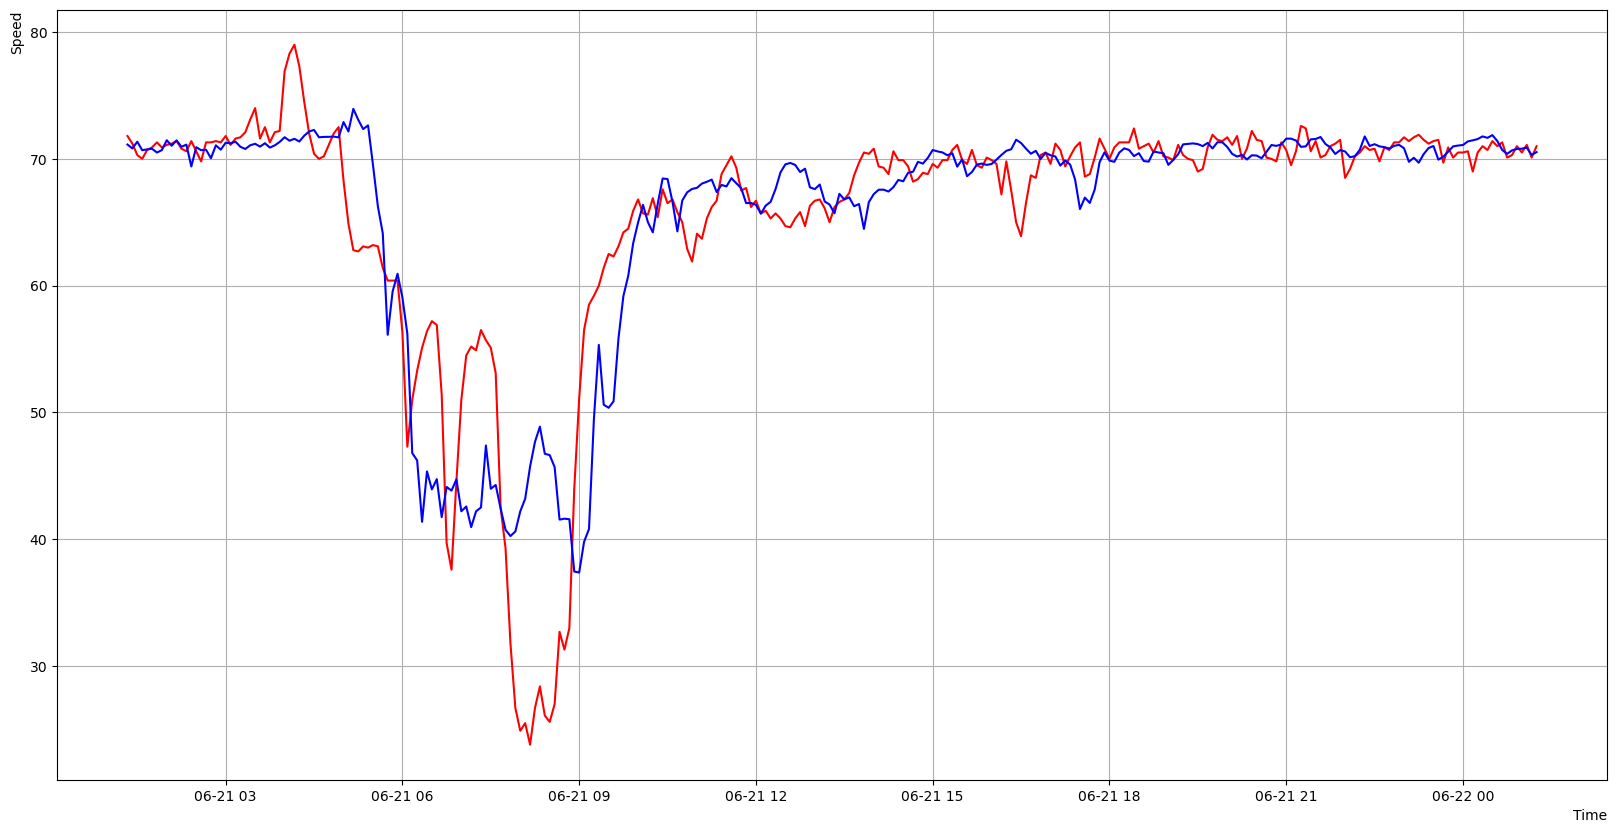

3.095578172471788


In [12]:
d1_start = prev_len + next_step - 1
start_offset = 288*20

time_len = 288 * 1
road_idx = 0

d = pd.read_csv(cur_data[2])
x = [cur_data[5] + i*datetime.timedelta(minutes=5) for i in range(d1_start+start_offset, d1_start+start_offset+time_len)]
d1 = d.iloc[d1_start+start_offset:d1_start+start_offset+time_len, road_idx]
d1 = pd.Series(d1).set_axis(x)
d2 = scaler.inverse_transform(result)[start_offset:time_len+start_offset, road_idx]
d2 = pd.Series(d2).set_axis(x)
show_plot(d1, d2)
print(np.abs((d1-d2)).mean())

In [13]:
mx = 0
mae = []
mse = []
mape = []
for i in range(len(d.iloc[0])):
    d1 = d.iloc[d1_start:, i].reset_index(drop=True)
    d2 = scaler.inverse_transform(result)[:,i]
    err = np.abs(d1-d2)
    print(i, err.mean())
    mx = max(mx, err.max())
    mae += err.to_list()
    mse += (err**2).to_list()
    mape += (err / d1).tolist()

mae_v = np.array(mae).mean()
rmse_v = np.sqrt(np.array(mse).mean())
mape_v = np.array(mape)
np.place(mape_v, np.isinf(mape_v), [0])
mape_v = mape_v.sum() / np.count_nonzero(mape_v)
print(f'MAX diff: {mx}, MAE: {mae_v}, RMSE: {rmse_v}, MAPE: {mape_v*100}%')

0 2.501223781371305
1 2.2702331614505398
2 3.604768073796894
3 2.5563808746355607
4 3.178454852248146
5 2.054607071325051
6 3.7240735154787554
7 2.115594732246452
8 2.9474737353840927
9 1.9281096644474642
10 5.354197005809212
11 2.302761075356037
12 1.2792615927267894
13 2.8932581576866934
14 1.4298383147562597
15 1.8303286369047327
16 1.0943250665872861
17 2.0867762420103264
18 0.9625434206631701
19 3.8328710162689448
20 2.5050530394232116
21 2.6254004122321684
22 1.438409416120771
23 2.9616492354698196
24 1.0417316544847715
25 1.9723678559410924
26 2.052558468687108
27 0.905940078703459
28 1.925940236190392
29 4.332821925695254
30 1.035016818208247
31 1.9133187400757632
32 2.794246362798224
33 2.7520569488163944
34 1.937900834254093
35 2.534406013373602
36 2.1092382173011095
37 2.1006660935383756
38 3.051798103888866
39 1.227238858936556
40 2.0193671811861713
41 2.317757940358801
42 2.065840142901642
43 2.9415626919662685
44 1.8232276304566577
45 5.205269778743768
46 4.91781544370868